[Following naklecha's repo](https://github.com/naklecha/llama3-from-scratch?tab=readme-ov-file)

# Tokenizer

In [1]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "Meta-Llama3.1-8B/tokenizer.model"
special_tokens = [
    "<|begin_of_text|>",
    "<|end_of_text|>",
    "<|reserved_special_token_0|>",
    "<|reserved_special_token_1|>",
    "<|reserved_special_token_2|>",
    "<|reserved_special_token_3|>",
    "<|start_header_id|>",
    "<|end_header_id|>",
    "<|reserved_special_token_4|>",
    "<|eot_id|>",  # end of turn
] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",  # Regex for tokenization
    mergeable_ranks=mergeable_ranks,
    special_tokens={
        token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)
    },
)

tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

# Model File

In [2]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
model = torch.load("Meta-Llama3.1-8B/consolidated.00.pth", map_location=device)
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [3]:
with open("Meta-Llama3.1-8B/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'ffn_dim_multiplier': 1.3,
 'multiple_of': 1024,
 'n_heads': 32,
 'n_kv_heads': 8,
 'n_layers': 32,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0,
 'use_scaled_rope': True,
 'vocab_size': 128256}

In [4]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

# Tokenization

In [5]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


In [6]:
prompt = "The quick brown fox jumps over the lazy dog and then"
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)
print(f"length: {len(tokens)}")

[128000, 791, 4062, 14198, 39935, 35308, 927, 279, 16053, 5679, 323, 1243]
['<|begin_of_text|>', 'The', ' quick', ' brown', ' fox', ' jumps', ' over', ' the', ' lazy', ' dog', ' and', ' then']
length: 12


# Embedding

In [7]:
embedding_layer = torch.nn.Embedding(vocab_size, embedding_dim=dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([12, 4096])

# RMS Norm

In [8]:
def rms_norm(tensor, norm_weights):
    variance = tensor.pow(2).mean(-1, keepdim=True)
    hidden_states = tensor * torch.rsqrt(variance + norm_eps)
    return hidden_states * norm_weights

In [9]:
token_embeddings = rms_norm(
    token_embeddings_unnormalized, model["layers.0.attention_norm.weight"]
)
print(token_embeddings.shape)  # same shape as token_embeddings_unnormalized

torch.Size([12, 4096])


# Attention

Note that `n_kv_heads` = `8` while `n_heads` = `32` ➡️ The dimension of query weight is `4 times` the dimension of key and value weights.

In [10]:
print(f"Query: {model['layers.0.attention.wq.weight'].shape}")
print(f"Key: {model['layers.0.attention.wk.weight'].shape}")
print(f"Value: {model['layers.0.attention.wv.weight'].shape}")
print(f"Output: {model['layers.0.attention.wo.weight'].shape}")

Query: torch.Size([4096, 4096])
Key: torch.Size([1024, 4096])
Value: torch.Size([1024, 4096])
Output: torch.Size([4096, 4096])


In [11]:
q_layer0 = model["layers.0.attention.wq.weight"]
print(f"Shape Before: {q_layer0.shape}")  # (dim, dim)
head_dim = dim // n_heads
print(f"Head dim = {head_dim}")
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
print(f"Shape After: {q_layer0.shape}")  # (n_heads, head_dim, dim)

Shape Before: torch.Size([4096, 4096])
Head dim = 128
Shape After: torch.Size([32, 128, 4096])


In [12]:
q_layer0_head0 = q_layer0[0]  # first head
print(f"Shape of first head: {q_layer0_head0.shape}")  # (head_dim, dim)

Shape of first head: torch.Size([128, 4096])


In [13]:
# Multiply the query weight with token embeddings to get the query for the tokens
q_per_token = token_embeddings @ q_layer0_head0.T
print(f"Shape: {q_per_token.shape}")  # (seq_flen, head_dim)

Shape: torch.Size([12, 128])


# Rotary Positional Embedding

In [14]:
# split into head_dim // 2 pairs, each pair will by rotated by m * theta where m is the position
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
print(
    f"Shape after splitting: {q_per_token_split_into_pairs.shape}"
)  # (seq_len, head_dim // 2, 2)

Shape after splitting: torch.Size([12, 64, 2])


If `head_dim` = `d` =  `128` and `rope_theta` = `500000`, then $\frac{d}{2}=64$

To get
$$
\theta_i = 500000^{-2i/d} = 500000^\frac{-i}{d/2} = 500000^\frac{-i}{128/2}
$$


We calculate `zero_to_one_split_into_64_parts` to get $\frac{i}{d/2}$ such that

$$
\left[0, \frac{1}{64}, \frac{2}{64}, \ldots, \frac{63}{64}\right]
$$

Then, $\text{freqs}$ will be calculated as:

$$
\text{freqs} = \left[1, \left(\frac{1}{500000}\right)^{1/64}, \left(\frac{1}{500000}\right)^{2/64}, \ldots, \left(\frac{1}{500000}\right)^{63/64}\right]
$$

This produces a sequence of decreasing frequencies. The first pair of dimensions will rotate the `slowest` (frequency of 1), and subsequent pairs will rotate `faster` as their frequencies decrease.

In [15]:
zero_to_one_split_into_64_parts = torch.tensor(range(head_dim // 2)) / (
    head_dim // 2
)  # 0, 1/64, 2/64, ..., 63/64
print(zero_to_one_split_into_64_parts)
freqs = 1.0 / (
    rope_theta**zero_to_one_split_into_64_parts
)  # 1, 1 / theta ** (1/64), 1 / theta ** (2/64), ..., 1 / theta ** (63/64)
print(freqs)

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])
tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7

shape is : torch.Size([12, 64])


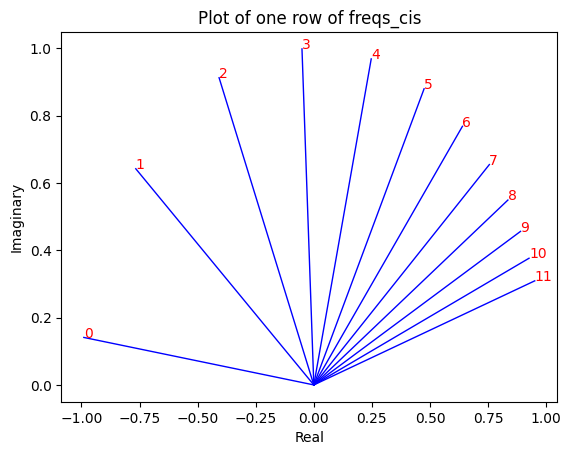

In [16]:
freqs_for_each_token = torch.outer(
    torch.arange(q_per_token_split_into_pairs.shape[0]), freqs
)  # Each element is the product of (2D Pair of tokens) * (the frequency)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
print(f"shape is : {freqs_cis.shape}")  # Unit complex numbers

# viewing the third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[: q_per_token_split_into_pairs.shape[0]]):
    plt.plot(
        [0, element.real],
        [0, element.imag],
        color="blue",
        linewidth=1,
        label=f"Index: {i}",
    )
    plt.annotate(f"{i}", xy=(element.real, element.imag), color="red")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.title("Plot of one row of freqs_cis")
plt.show()

## Apply on Queries

Shape of pairs (real): torch.Size([12, 64, 2])
Shape of pairs (complex): torch.Size([12, 64])
Shape of rotated pairs: torch.Size([12, 64])
Shape of rotated pairs (real): torch.Size([12, 64, 2])
Shape of rotated tokens: torch.Size([12, 128])


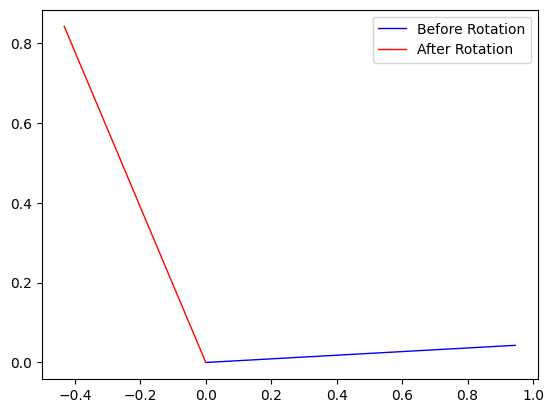

In [17]:
print(f"Shape of pairs (real): {q_per_token_split_into_pairs.shape}")
q_per_token_as_complex_numbers = torch.view_as_complex(
    q_per_token_split_into_pairs
)  # Convert each pair to a complex number
print(f"Shape of pairs (complex): {q_per_token_as_complex_numbers.shape}")
# Apply rotation
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
print(f"Shape of rotated pairs: {q_per_token_as_complex_numbers_rotated.shape}")
# Convert back to real numbers
q_per_token_split_into_pairs_rotated = torch.view_as_real(
    q_per_token_as_complex_numbers_rotated
)
print(f"Shape of rotated pairs (real): {q_per_token_split_into_pairs_rotated.shape}")
# Reshape to original shape
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
print(f"Shape of rotated tokens: {q_per_token_rotated.shape}")

token_idx = 2
# plot the second token before and after rotation
plt.figure()
plt.plot(
    [0, q_per_token_split_into_pairs[token_idx, 0, 0].detach().numpy()],
    [0, q_per_token_split_into_pairs[token_idx, 0, 1].detach().numpy()],
    color="blue",
    linewidth=1,
    label="Before Rotation",
)
plt.plot(
    [0, q_per_token_split_into_pairs_rotated[token_idx, 0, 0].detach().numpy()],
    [0, q_per_token_split_into_pairs_rotated[token_idx, 0, 1].detach().numpy()],
    color="red",
    linewidth=1,
    label="After Rotation",
)
plt.legend()

## Apply on Keys
Note that number of kv heads is $\frac{1}{4}$ number of heads.

In [18]:
k_layer0 = model["layers.0.attention.wk.weight"]
print(f"Shape before: {k_layer0.shape}")
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
print(f"Shape after: {k_layer0.shape}")
k_layer0_head0 = k_layer0[0]
print(f"Shape of first head: {k_layer0_head0.shape}")
k_per_token = token_embeddings @ k_layer0_head0.T
print(f"Shape: {k_per_token.shape}")

Shape before: torch.Size([1024, 4096])
Shape after: torch.Size([8, 128, 4096])
Shape of first head: torch.Size([128, 4096])
Shape: torch.Size([12, 128])


In [19]:
# Apply positional encoding
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
print(f"Shape after splitting: {k_per_token_split_into_pairs.shape}")
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
print(f"Shape of pairs (complex): {k_per_token_as_complex_numbers.shape}")
k_per_token_as_complex_numbers_rotated = k_per_token_as_complex_numbers * freqs_cis
print(f"Shape of rotated pairs: {k_per_token_as_complex_numbers_rotated.shape}")
k_per_token_split_into_pairs_rotated = torch.view_as_real(
    k_per_token_as_complex_numbers_rotated
)
print(f"Shape of rotated pairs (real): {k_per_token_split_into_pairs_rotated.shape}")
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
print(f"Shape of rotated tokens: {k_per_token_rotated.shape}")

Shape after splitting: torch.Size([12, 64, 2])
Shape of pairs (complex): torch.Size([12, 64])
Shape of rotated pairs: torch.Size([12, 64])
Shape of rotated pairs (real): torch.Size([12, 64, 2])
Shape of rotated tokens: torch.Size([12, 128])


# Values

In [20]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0_head0 = v_layer0[0]
v_per_token = token_embeddings @ v_layer0_head0.T

# Scaled Dot Product Attention

In [21]:
qk_per_token = q_per_token_rotated @ k_per_token_rotated.T
qk_per_token = qk_per_token / (head_dim**0.5)
print(f"Shape: {qk_per_token.shape}")

Shape: torch.Size([12, 12])


In [22]:
# Apply masking
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
qk_per_token_after_masking = qk_per_token + mask
qk_per_token_after_masking[:5, :5]

tensor([[3.7595,   -inf,   -inf,   -inf,   -inf],
        [8.8772, 6.3576,   -inf,   -inf,   -inf],
        [9.2076, 8.3401, 5.1851,   -inf,   -inf],
        [8.3824, 7.9961, 6.5433, 5.2781,   -inf],
        [8.4780, 8.0762, 7.2457, 7.0795, 6.0598]], grad_fn=<SliceBackward0>)

In [23]:
# Apply softmax
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(
    qk_per_token_after_masking, dim=1
).to(torch.bfloat16)

In [24]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)

# Multi Head Attention

In [25]:
qkv_attention_store = []
for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head // 4]
    v_layer0_head = v_layer0[head // 4]

    q_per_token = token_embeddings @ q_layer0_head.T
    k_per_token = token_embeddings @ k_layer0_head.T
    v_per_token = token_embeddings @ v_layer0_head.T

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
    q_per_token_split_into_pairs_rotated = torch.view_as_real(
        q_per_token_as_complex_numbers_rotated
    )

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_as_complex_numbers_rotated = k_per_token_as_complex_numbers * freqs_cis
    k_per_token_split_into_pairs_rotated = torch.view_as_real(
        k_per_token_as_complex_numbers_rotated
    )

    qk_per_token = q_per_token_rotated @ k_per_token_rotated.T
    qk_per_token = qk_per_token / (head_dim**0.5)
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(
        qk_per_token_after_masking, dim=1
    ).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

print(f"Verify number of heads: {len(qkv_attention_store)}")
print(f"Dims of each head: {qkv_attention_store[0].shape}")

Verify number of heads: 32
Dims of each head: torch.Size([12, 128])


In [26]:
# Concatenate the heads
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
print(f"Shape after concatenation: {stacked_qkv_attention.shape}")
# Apply the output weight
w_layer0 = model["layers.0.attention.wo.weight"]
print(f"Shape of outout layer: {w_layer0.shape}")
embedding_delta = stacked_qkv_attention @ w_layer0.T
print(f"Shape of embedding_delta: {embedding_delta.shape}")
# Add the delta to the token embeddings
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
print(f"Shape of embeddings after edit: {embedding_after_edit.shape}")

Shape after concatenation: torch.Size([12, 4096])
Shape of outout layer: torch.Size([4096, 4096])


Shape of embedding_delta: torch.Size([12, 4096])
Shape of embeddings after edit: torch.Size([12, 4096])


# MLP

In [27]:
# Normalize the embeddings
embedding_after_edit_normalized = rms_norm(
    embedding_after_edit, model["layers.0.ffn_norm.weight"]
)

![SwiGlu](https://github.com/naklecha/llama3-from-scratch/raw/main/images/swiglu.png)

In [28]:
w_gate = model["layers.0.feed_forward.w1.weight"]
w_down = model["layers.0.feed_forward.w2.weight"]
w_up = model["layers.0.feed_forward.w3.weight"]

embd_w_gate = embedding_after_edit_normalized @ w_gate.T
print(f"shape of embd_w_gate: {embd_w_gate.shape}")
# apply silu
silu = torch.nn.functional.silu(embd_w_gate)
embd_w_up = embedding_after_edit_normalized @ w_up.T
print(f"shape of embd_w_up: {embd_w_up.shape}")
# multiply both
embd_w_gate * embd_w_up
# apply w_down
output_after_feedforward = silu * embd_w_up @ w_down.T
print(f"shape of output_after_feedforward: {output_after_feedforward.shape}")

shape of embd_w_gate: torch.Size([12, 14336])
shape of embd_w_up: torch.Size([12, 14336])
shape of output_after_feedforward: torch.Size([12, 4096])


In [29]:
# add the output to the embeddings
embedding_after_feedforward = embedding_after_edit + output_after_feedforward
print(f"shape of embedding_after_feedforward: {embedding_after_feedforward.shape}")

shape of embedding_after_feedforward: torch.Size([12, 4096])


# Apply for all layers

In [30]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)

    qkv_attention_store = []
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head // 4]
        v_layer_head = v_layer[head // 4]

        q_per_token = final_embedding @ q_layer_head.T
        k_per_token = final_embedding @ k_layer_head.T
        v_per_token = final_embedding @ v_layer_head.T

        q_per_token_split_into_pairs = q_per_token.float().view(
            q_per_token.shape[0], -1, 2
        )
        q_per_token_as_complex_numbers = torch.view_as_complex(
            q_per_token_split_into_pairs
        )
        q_per_token_as_complex_numbers_rotated = (
            q_per_token_as_complex_numbers * freqs_cis
        )
        q_per_token_split_into_pairs_rotated = torch.view_as_real(
            q_per_token_as_complex_numbers_rotated
        )

        k_per_token_split_into_pairs = k_per_token.float().view(
            k_per_token.shape[0], -1, 2
        )
        k_per_token_as_complex_numbers = torch.view_as_complex(
            k_per_token_split_into_pairs
        )
        k_per_token_as_complex_numbers_rotated = (
            k_per_token_as_complex_numbers * freqs_cis
        )
        k_per_token_split_into_pairs_rotated = torch.view_as_real(
            k_per_token_as_complex_numbers_rotated
        )

        qk_per_token = q_per_token_rotated @ k_per_token_rotated.T
        qk_per_token = qk_per_token / (head_dim**0.5)
        mask = torch.full(
            (len(tokens), len(tokens)), float("-inf"), device=tokens.device
        )
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(
            qk_per_token, dim=1
        ).to(torch.bfloat16)
        qkv_attention = torch.matmul(
            qk_per_token_after_masking_after_softmax, v_per_token
        )
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = stacked_qkv_attention @ w_layer.T
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(
        embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"]
    )
    embd_w_gate = (
        embedding_after_edit_normalized
        @ model[f"layers.{layer}.feed_forward.w1.weight"].T
    )
    silu = torch.nn.functional.silu(embd_w_gate)
    embd_w_up = (
        embedding_after_edit_normalized
        @ model[f"layers.{layer}.feed_forward.w3.weight"].T
    )
    output_after_feedforward = (
        silu * embd_w_up @ model[f"layers.{layer}.feed_forward.w2.weight"].T
    )
    final_embedding = embedding_after_edit + output_after_feedforward

In [31]:
# Apply norm on final embedding
final_embedding = rms_norm(final_embedding, model["norm.weight"])
print(f"Shape of final embedding: {final_embedding.shape}")

Shape of final embedding: torch.Size([12, 4096])


In [32]:
# Predict the Next Token
logits = final_embedding[-1] @ model["output.weight"].T
print(f"Shape of logits: {logits.shape}")
next_token = torch.argmax(logits, dim=-1)
print(f"Next token: {next_token}")
decoded_next_token = tokenizer.decode([next_token.item()])
print(f"Decoded next token: {decoded_next_token}")

Shape of logits: torch.Size([128256])
Next token: 43366
Decoded next token: brook
